In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
sns.set_theme()
sns.set_context("paper")  # paper, notebook, talk, and poster

# Compute Effective Dimension

25 tensor(0.3154) tensor(0.3186)
230 tensor(0.3332) tensor(0.3365)


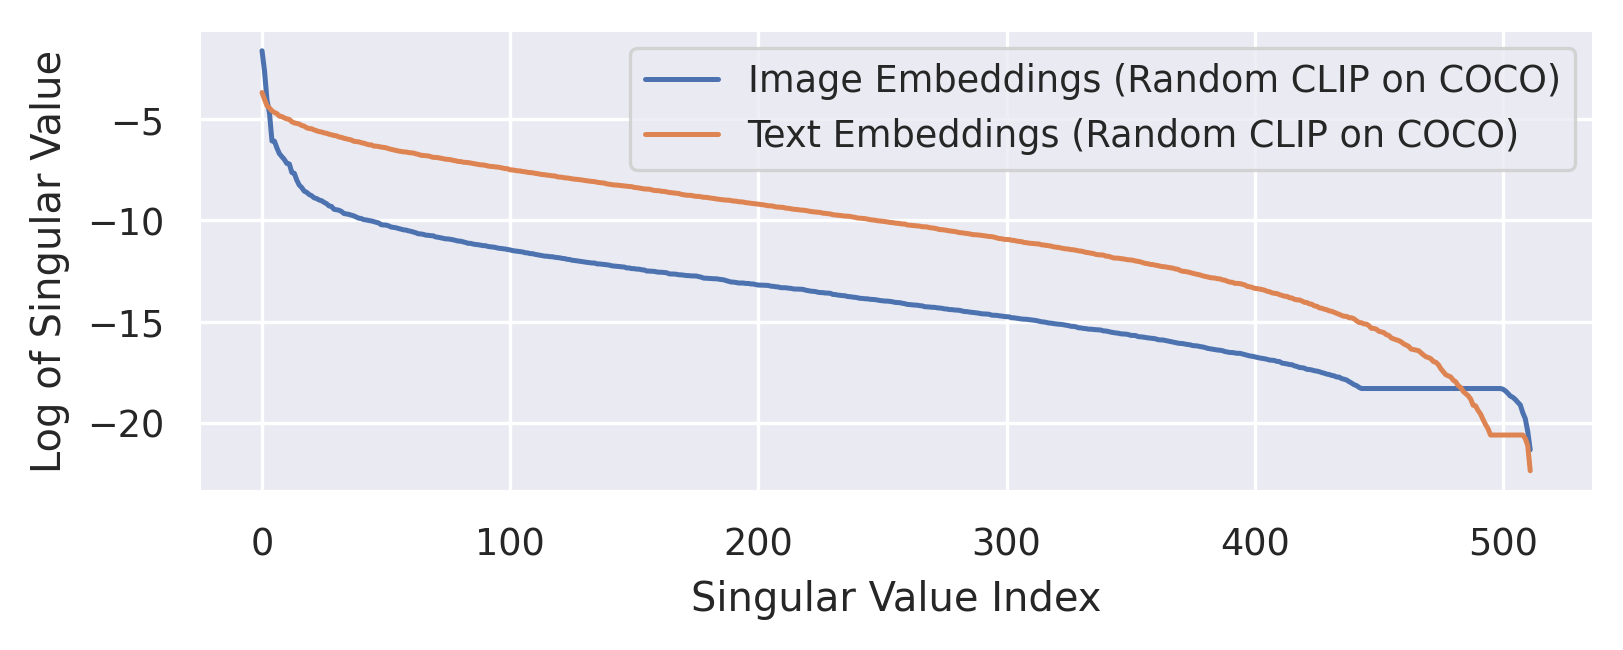

In [2]:
plt.figure(figsize=(6, 2))
features = np.load("features_clip_random.npy")
image_features = torch.from_numpy(features[0])
text_features = torch.from_numpy(features[1])

u, sigma_image, v = torch.svd(torch.cov(image_features.T))
plt.plot(torch.log(sigma_image), label="Image Embeddings (Random CLIP on COCO)")

u, sigma_text, v = torch.svd(torch.cov(text_features.T))
plt.plot(torch.log(sigma_text), label="Text Embeddings (Random CLIP on COCO)")

plt.xlabel("Singular Value Index")
plt.ylabel("Log of Singular Value")
plt.legend()

i = 0
while True:
    i += 1
    if sigma_image[:i].sum() / sigma_image.sum() > 0.99:
        break
print(i, sigma_image[:i].sum(), sigma_image.sum())

i = 0
while True:
    i += 1
    if sigma_text[:i].sum() / sigma_text.sum() > 0.99:
        break
print(i, sigma_text[:i].sum(), sigma_text.sum())

1.0004745787382125


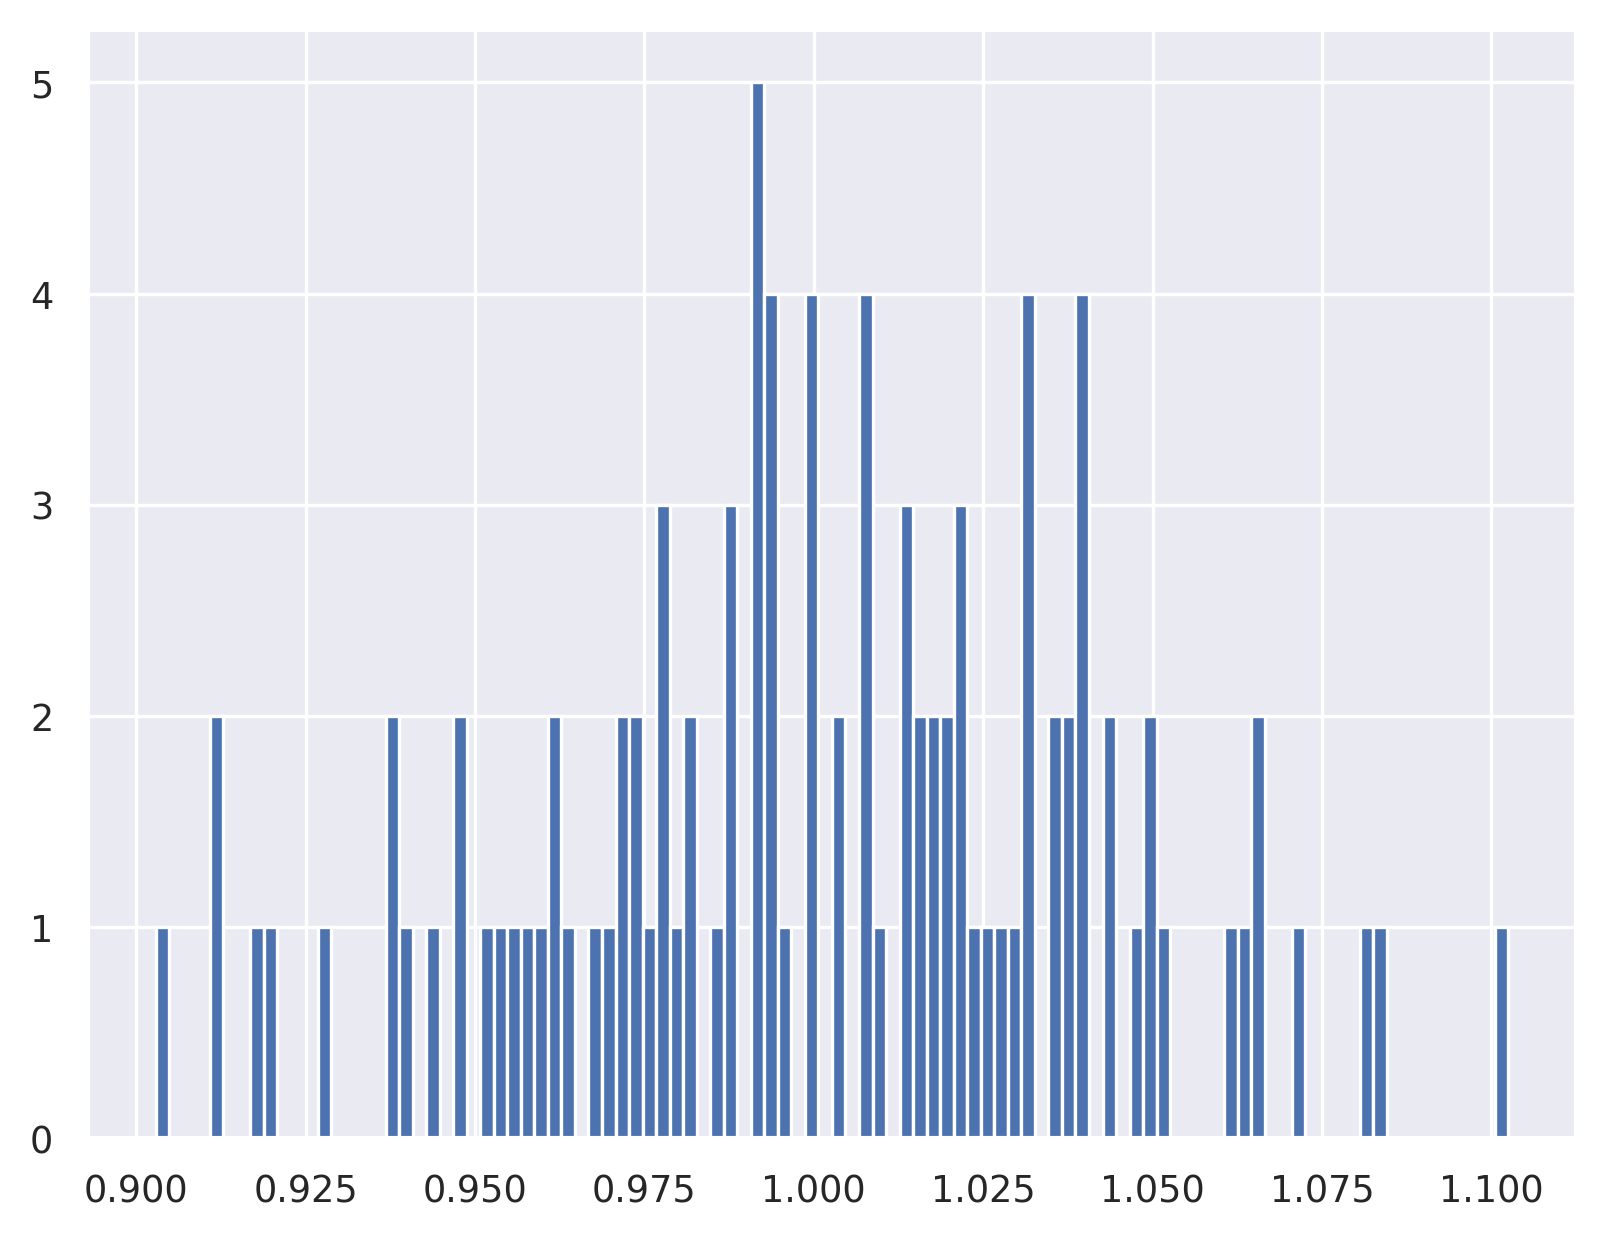

In [3]:
distances = []

for i in range(100):
    feature1 = torch.randn(1, 257).repeat(10000, 1)
    feature2 = torch.randn(1, 257).repeat(10000, 1)
    features1 = torch.cat([torch.randn(10000, 255), feature1], dim=1)
    features2 = torch.cat([torch.randn(10000, 255), feature2], dim=1)

    distance = (
        F.normalize(features1).mean(dim=0) - F.normalize(features2).mean(dim=0)
    ).norm()
    distances.append(distance.item())

plt.hist(distances, bins=100)
print(np.mean(distances))

# Study Gradient Direction

0 6.266750335693359 tensor(1.2478, device='cuda:0', grad_fn=<NormBackward1>) tensor(1.0228, device='cuda:0', grad_fn=<NormBackward1>) tensor(2.6593, device='cuda:0')


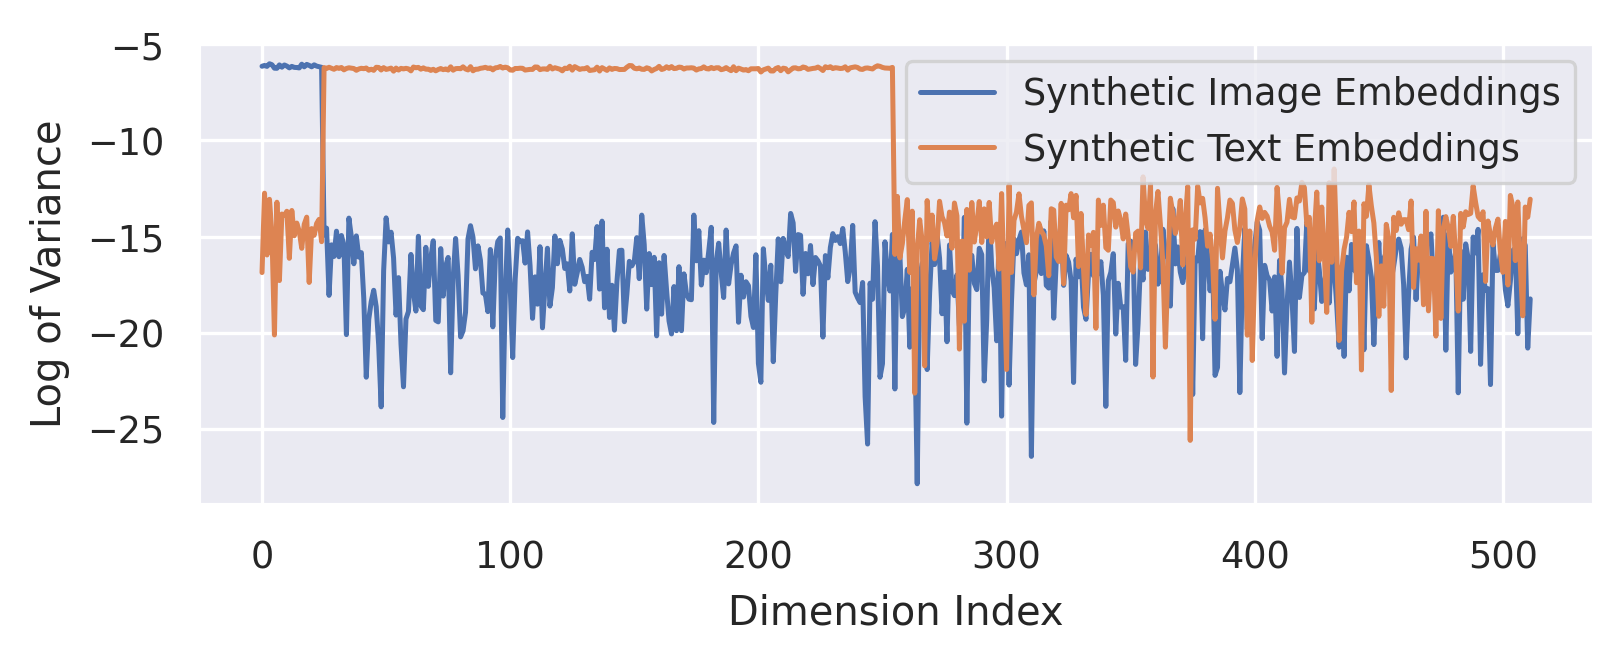

20000 5.395140647888184 tensor(1.2438, device='cuda:0', grad_fn=<NormBackward1>) tensor(1.0199, device='cuda:0', grad_fn=<NormBackward1>) tensor(2.6593, device='cuda:0')


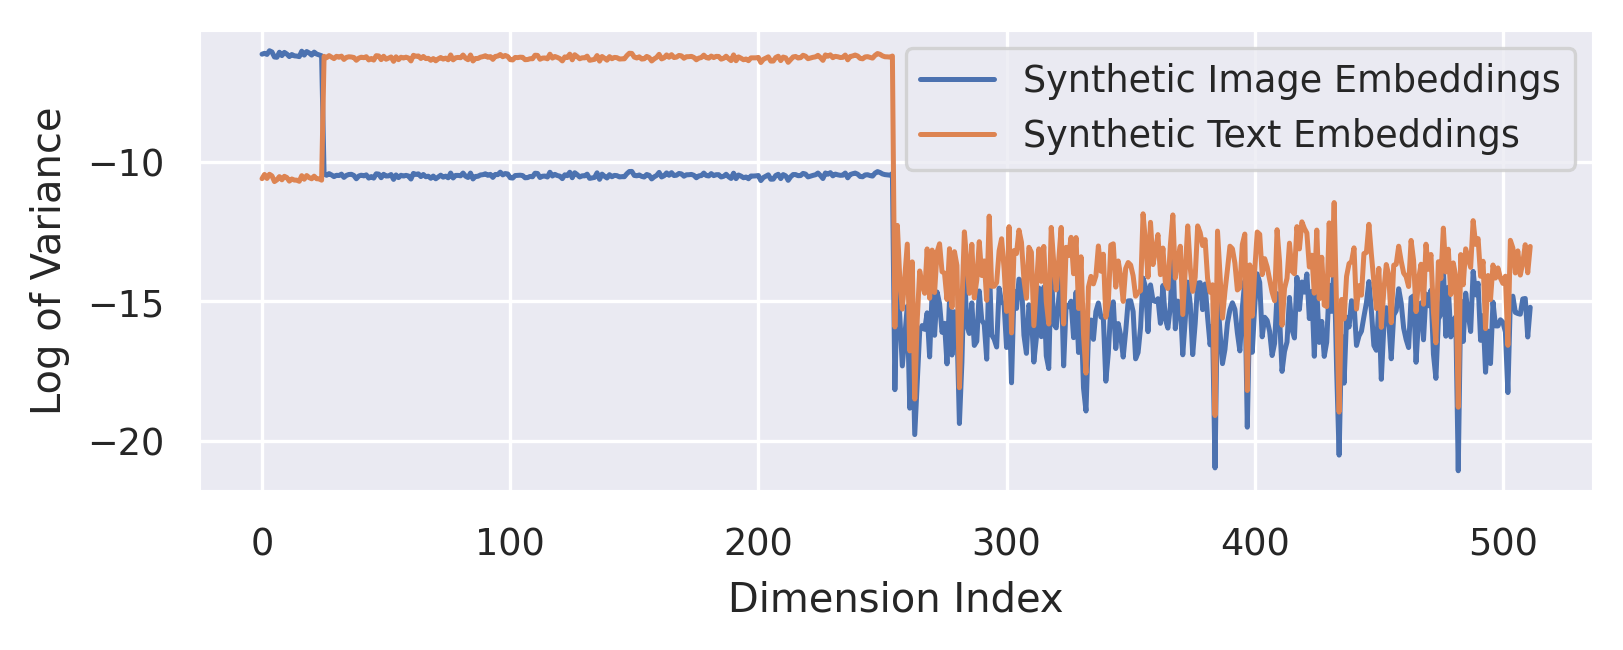

40000 4.555586814880371 tensor(1.2314, device='cuda:0', grad_fn=<NormBackward1>) tensor(1.0101, device='cuda:0', grad_fn=<NormBackward1>) tensor(2.6593, device='cuda:0')


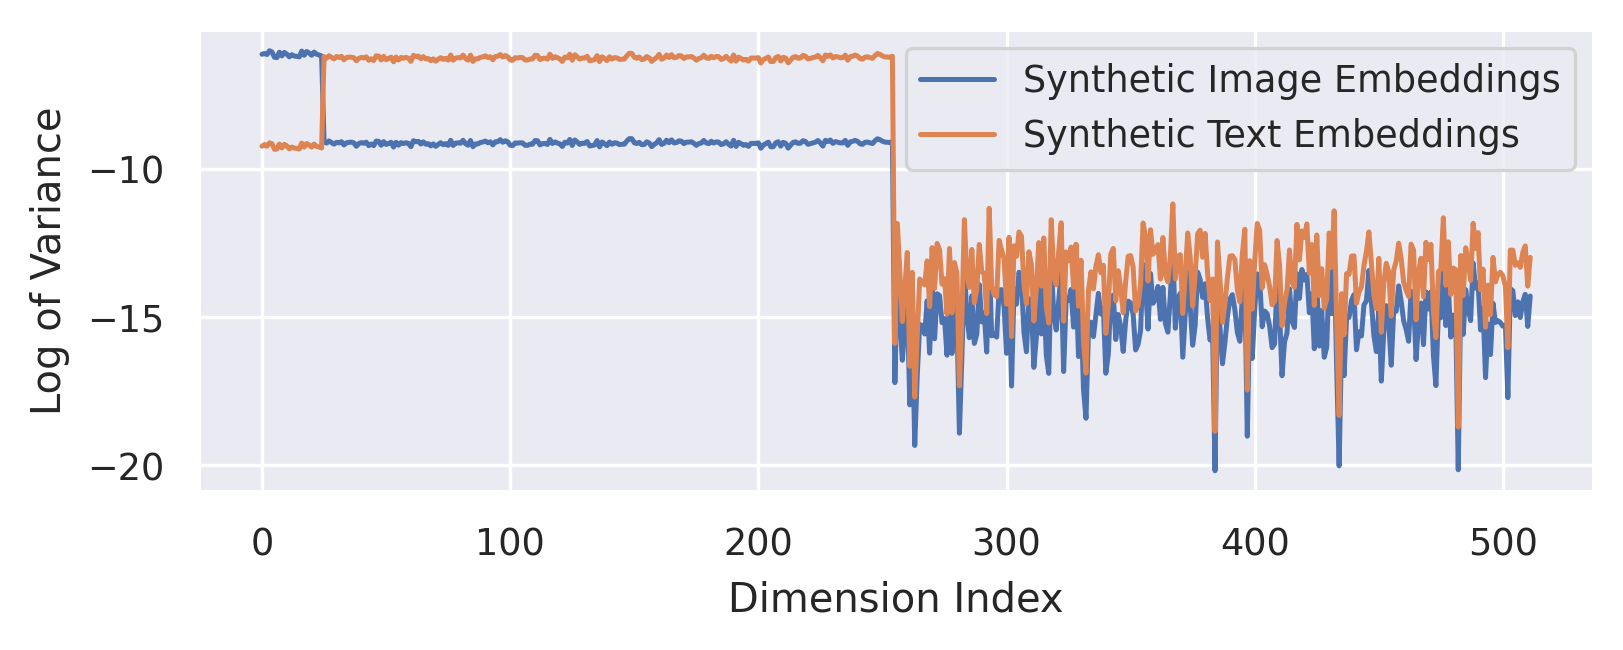

60000 3.726677179336548 tensor(1.2110, device='cuda:0', grad_fn=<NormBackward1>) tensor(0.9938, device='cuda:0', grad_fn=<NormBackward1>) tensor(2.6593, device='cuda:0')


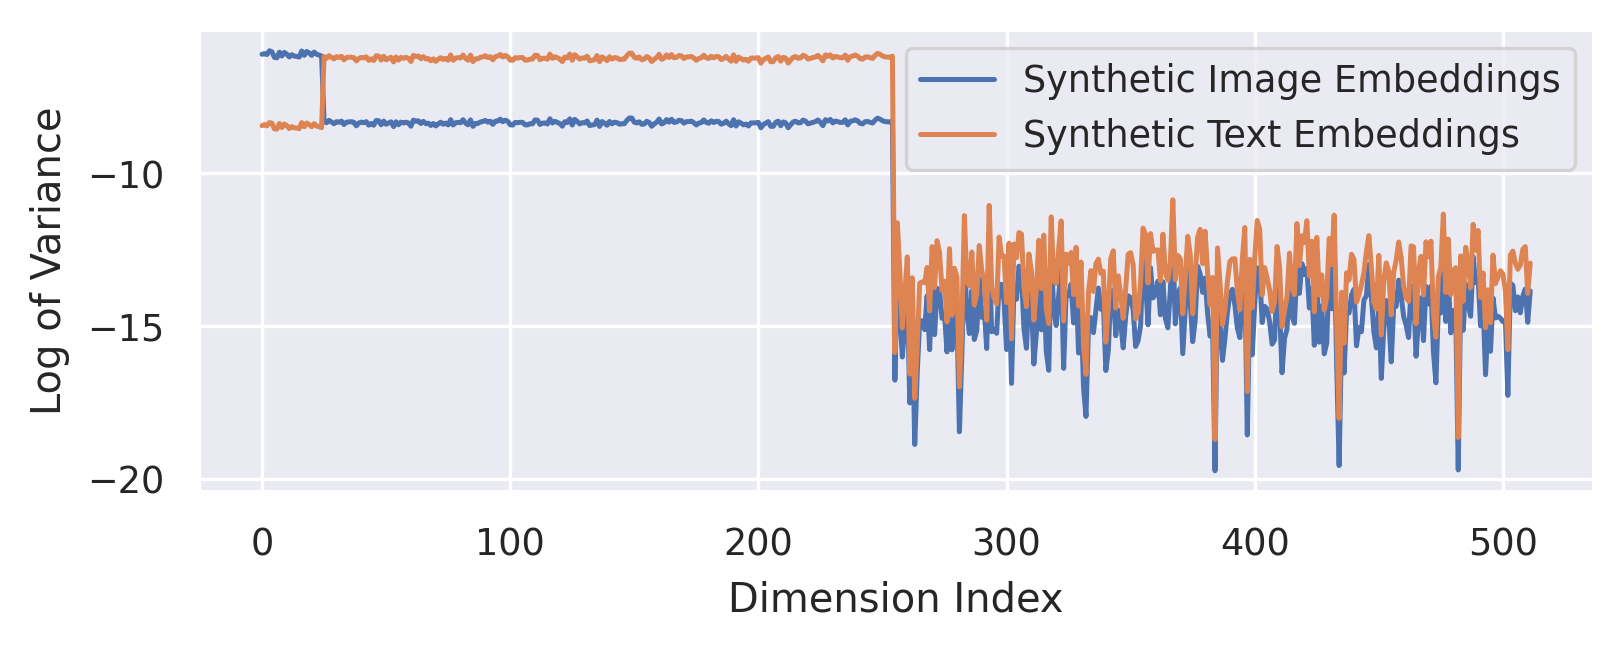

80000 2.9195785522460938 tensor(1.1837, device='cuda:0', grad_fn=<NormBackward1>) tensor(0.9718, device='cuda:0', grad_fn=<NormBackward1>) tensor(2.6593, device='cuda:0')


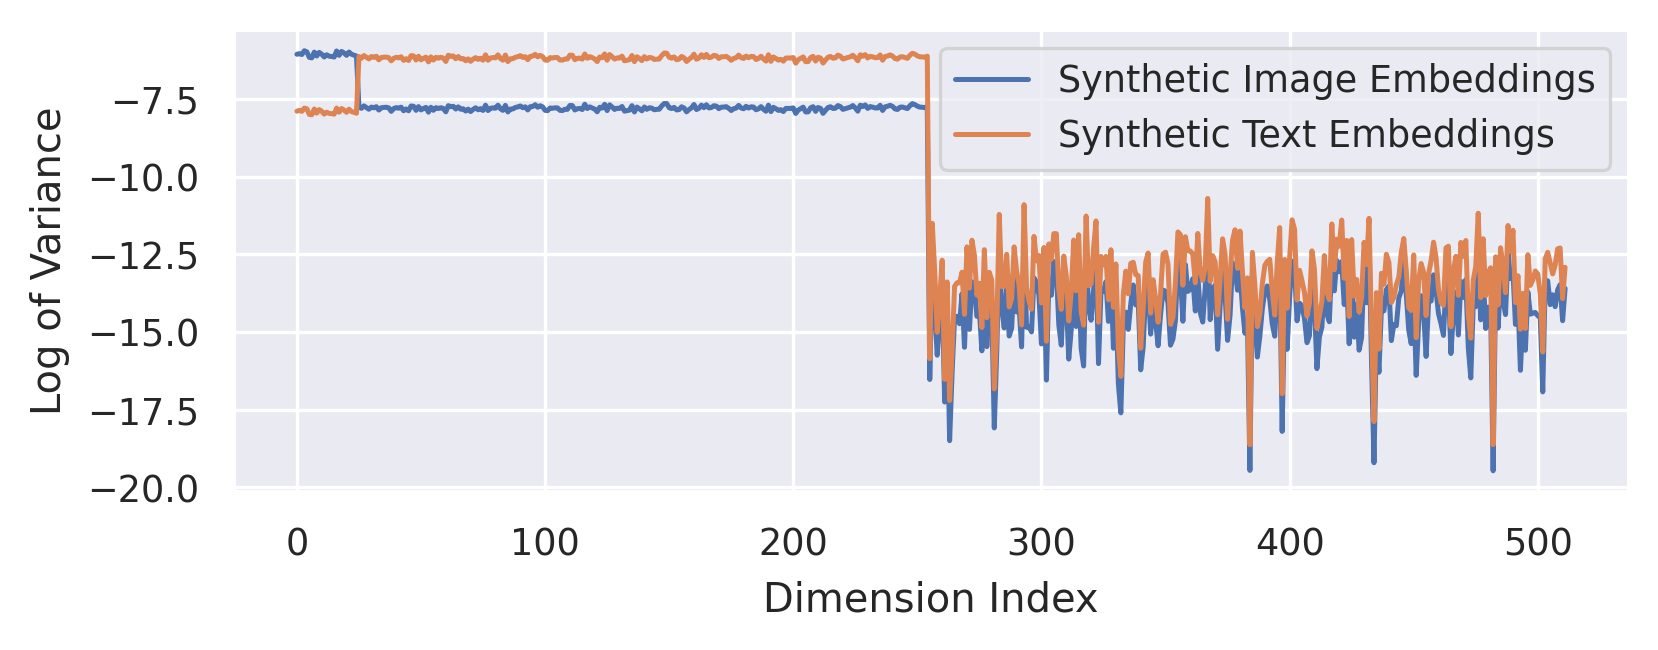

In [6]:
N = 500
d_e1 = 25
d_e2 = 230
d_ie = 512 - d_e1 - d_e2

x_c1, x_c2, y_c1, y_c2 = (
    torch.randn(1, d_e2),
    torch.randn(1, d_ie),
    torch.randn(1, d_e1),
    torch.randn(1, d_ie),
)
x_c1, x_c2, y_c1, y_c2 = (
    x_c1.repeat(N, 1),
    x_c2.repeat(N, 1),
    y_c1.repeat(N, 1),
    y_c2.repeat(N, 1),
)
x = torch.cat([torch.randn(N, d_e1), x_c1, x_c2], dim=1).cuda().requires_grad_(True)
y = torch.cat([y_c1, torch.randn(N, d_e2), y_c2], dim=1).cuda().requires_grad_(True)

tau = torch.tensor(2.6593).cuda().requires_grad_(False)
labels = torch.arange(N).cuda()

optimizer = torch.optim.SGD([x, y, tau], lr=0.1)

for i in range(100000):
    sims = (F.normalize(x) @ F.normalize(y).T) * torch.exp(tau)
    loss = (
        torch.nn.functional.cross_entropy(sims, labels)
        + torch.nn.functional.cross_entropy(sims.T, labels)
    ) / 2

    if i % 20000 == 0:
        gap = (F.normalize(x).mean(dim=0) - F.normalize(y).mean(dim=0)).norm()
        gap_ie = (
            F.normalize(x)[:, -d_ie:].mean(dim=0)
            - F.normalize(y)[:, -d_ie:].mean(dim=0)
        ).norm()

        print(i, loss.item(), gap, gap_ie, tau)

        plt.figure(figsize=(6, 2))
        plt.plot(
            torch.log(F.normalize(x.cpu().detach()).std(dim=0).detach() ** 2),
            label="Synthetic Image Embeddings",
        )
        plt.plot(
            torch.log(F.normalize(y.cpu().detach()).std(dim=0).detach() ** 2),
            label="Synthetic Text Embeddings",
        )
        plt.legend()

        plt.xlabel("Dimension Index")
        plt.ylabel("Log of Variance")
        plt.show()

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    tau.data = torch.clamp(tau.data, 0, 4.6052)

# MLP Singular Values

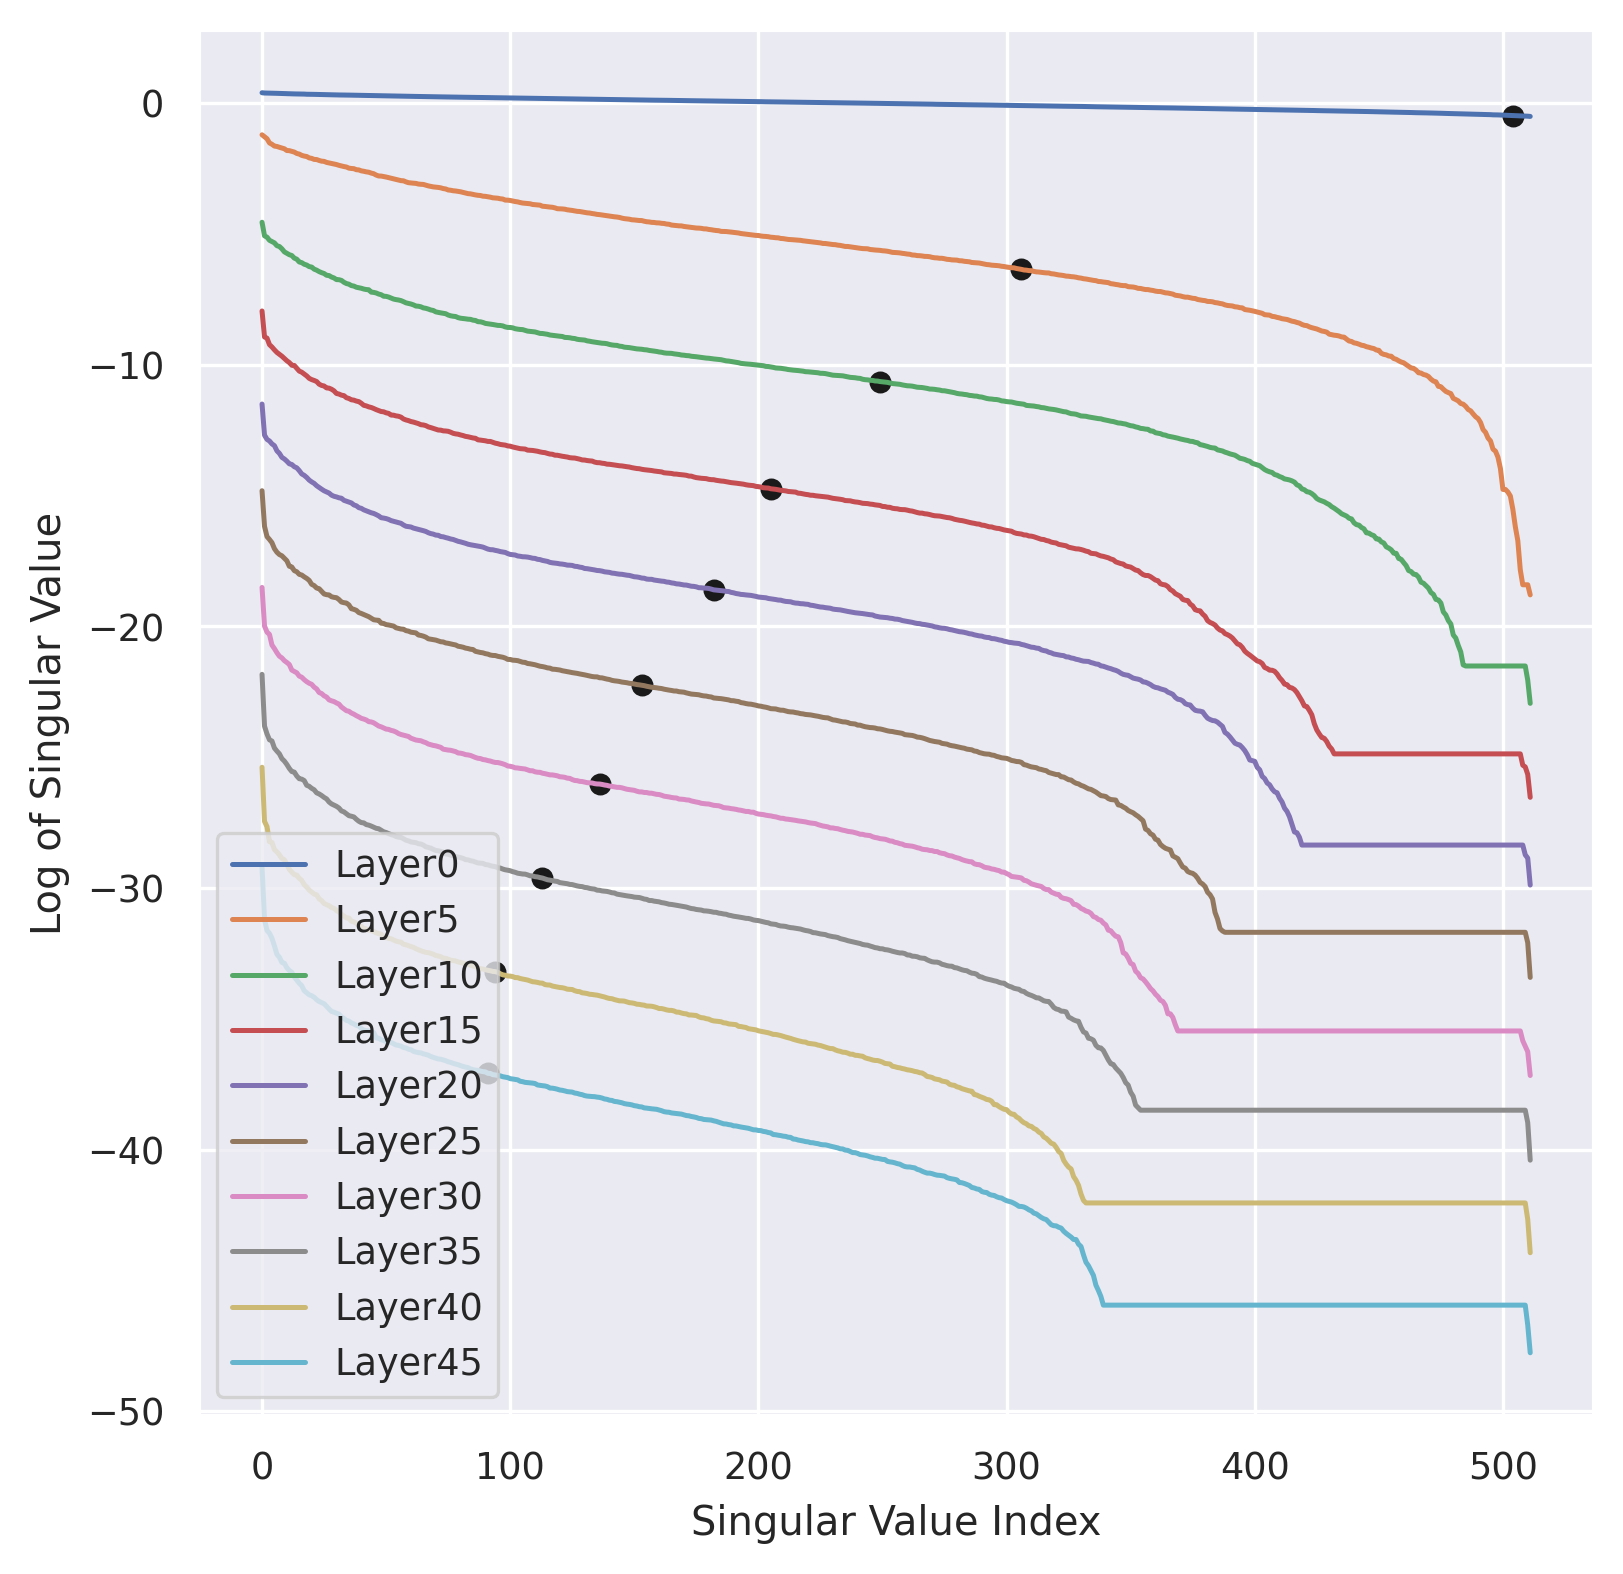

In [7]:
class MLP(nn.Module):
    def __init__(self, dim, n_layer):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(dim, dim) for _ in range(n_layer)])
        self.init()

    def init(self):
        for layer in self.layers:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        features = []
        for layer in self.layers:
            x_ = layer(x)
            features.append(x_)
            x = F.relu(x_)
        return features


mlp = MLP(512, 50)

input_features = torch.randn(10000, 512)
with torch.no_grad():
    features = mlp(input_features)
features = [input_features] + features


plt.figure(figsize=(6, 6))
for i in range(0, 50, 5):
    cov = torch.cov(features[i].T)
    u, sigma, v = torch.svd(cov)

    idx = 0
    while True:
        idx += 1
        if sigma[:idx].sum() / sigma.sum() > 0.99:
            break

    # draw a point at the end of the 99% variance line
    plt.scatter(idx, torch.log(sigma[idx]), s=20, c="k")

    plt.plot(torch.log(sigma), label=f"Layer{i}")
plt.legend()
plt.xlabel("Singular Value Index")
plt.ylabel("Log of Singular Value")
plt.show()